<a href="https://colab.research.google.com/github/imaboylol/cardiology-analysis/blob/main/heart_failure_prediction/heart_failure_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Failure Prediction: different models test

Kaggle Dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

Authors:\
https://github.com/imaboylol \
https://github.com/Gromwud

All necessary imports

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

Dataset loading

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!gdown # your google drive link to .csv

Downloading...
From: https://drive.google.com/uc?id=1f0MS90uFqhkwtSyOGzQ4XO4sSN3aGEfB
To: /content/heart.csv
100% 35.9k/35.9k [00:00<00:00, 67.4MB/s]


In [16]:
#kaggle path: ('../input/heart-failure-prediction/heart.csv')
df = pd.read_csv('heart.csv')

## Exploratory Data Analysis (EDA) & Data Visualization

Evaluate the dataset structure

In [17]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


To work with the data we will split the dataset into numerical and categorical features in advance

In [19]:
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


Now evaluate the correlation between the target categorical feature 'Heart Disease' and the numerical features

In [20]:
px.imshow(df.corr(), title="Correlation Heart Disease - Numerical features")

Further, for preprocessing, it is worth knowing the distribution of the target variable in the training sample

In [21]:
fig=px.histogram(df,
                 x="HeartDisease",
                 color="Sex",
                 hover_data=df.columns,
                 title="'Heart Disease' distribution in training sample",
                 barmode="group")
fig.show()

Heart Disease == 0, No disease: 267 M + 143 F = 410\
Heart Disease == 1, Disease detected: 458 M + 50 F = 508\

Thus, the distribution of Heart Disease: 44.6% to 55.3%, and k-fold cross-validation should be used

Also, in analyzing cardiac data, it is extremely useful to know the distribution of various medical parameters in the presence and absence of disease:

In [22]:
fig=px.histogram(df,
                 x="ChestPainType",
                 color="HeartDisease",
                 hover_data=df.columns,
                 title="ChestPainType distribution"
                )
fig.show()

In [23]:
fig=px.histogram(df,
                 x="RestingECG",
                 hover_data=df.columns,
                 color="HeartDisease",
                 title="Distribution of Resting ECG")
fig.show()

In [24]:
fig=px.histogram(df,
                 x="FastingBS",
                 hover_data=df.columns,
                 color="HeartDisease",
                 title="Distribution of FastingBS - Fasting Blood Sugar")
fig.show()

In [25]:
fig=px.histogram(df,
                 x="ExerciseAngina",
                 hover_data=df.columns,
                 color="HeartDisease",
                 title="The correlation between angina and heart disease")
fig.show()

In [26]:
fig=px.histogram(df,
                 x="ST_Slope",
                 hover_data=df.columns,
                 color="HeartDisease",
                 title="ST_Slope & Heart Disease correlation")
fig.show()

Also compare the numerical features in pairs

[]

<Figure size 1500x1000 with 0 Axes>

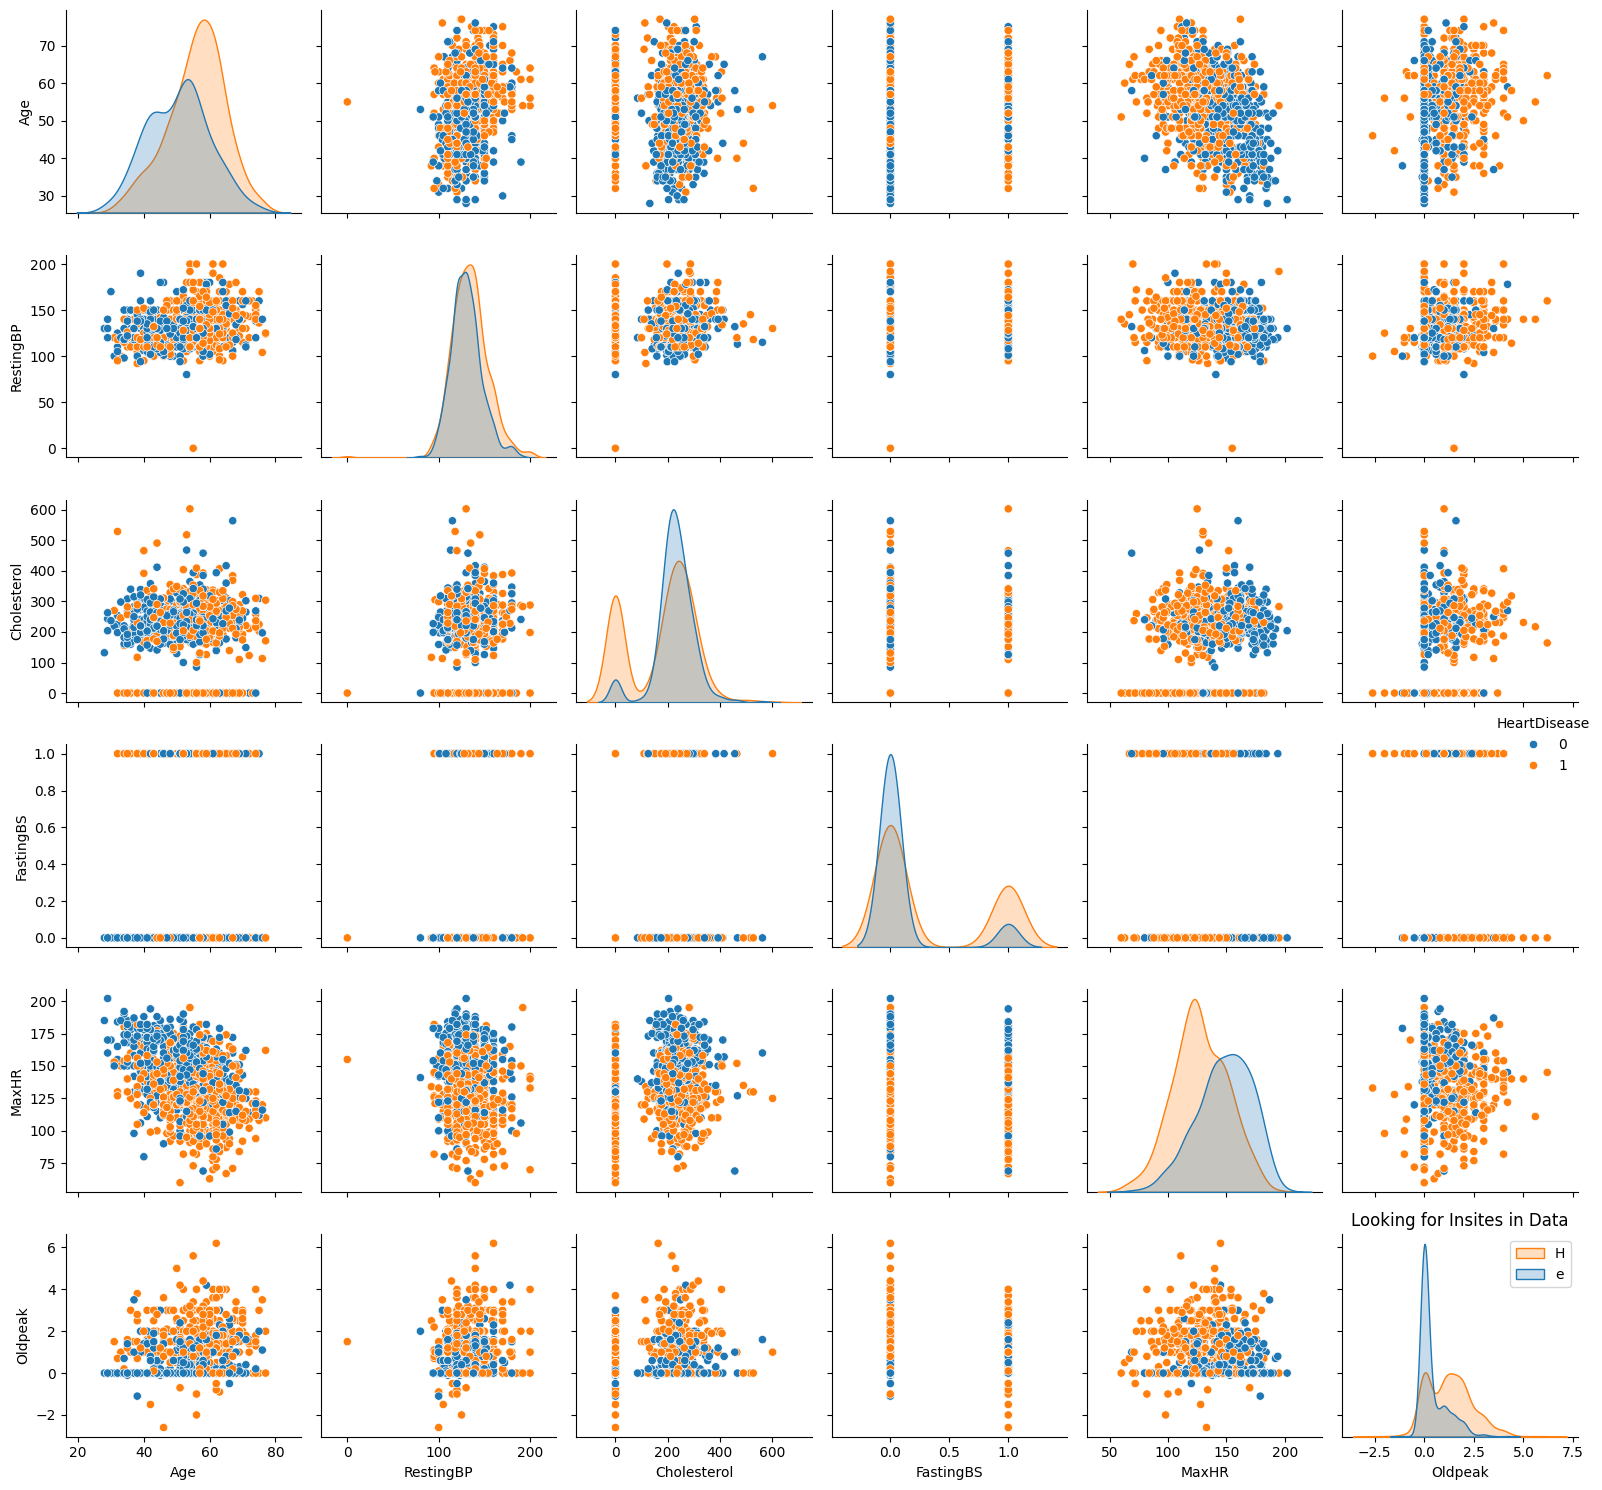

In [27]:
plt.figure(figsize=(15,10))
sns.pairplot(df,hue="HeartDisease")
plt.title("Looking for Insites in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

Consider the distribution of numerical features

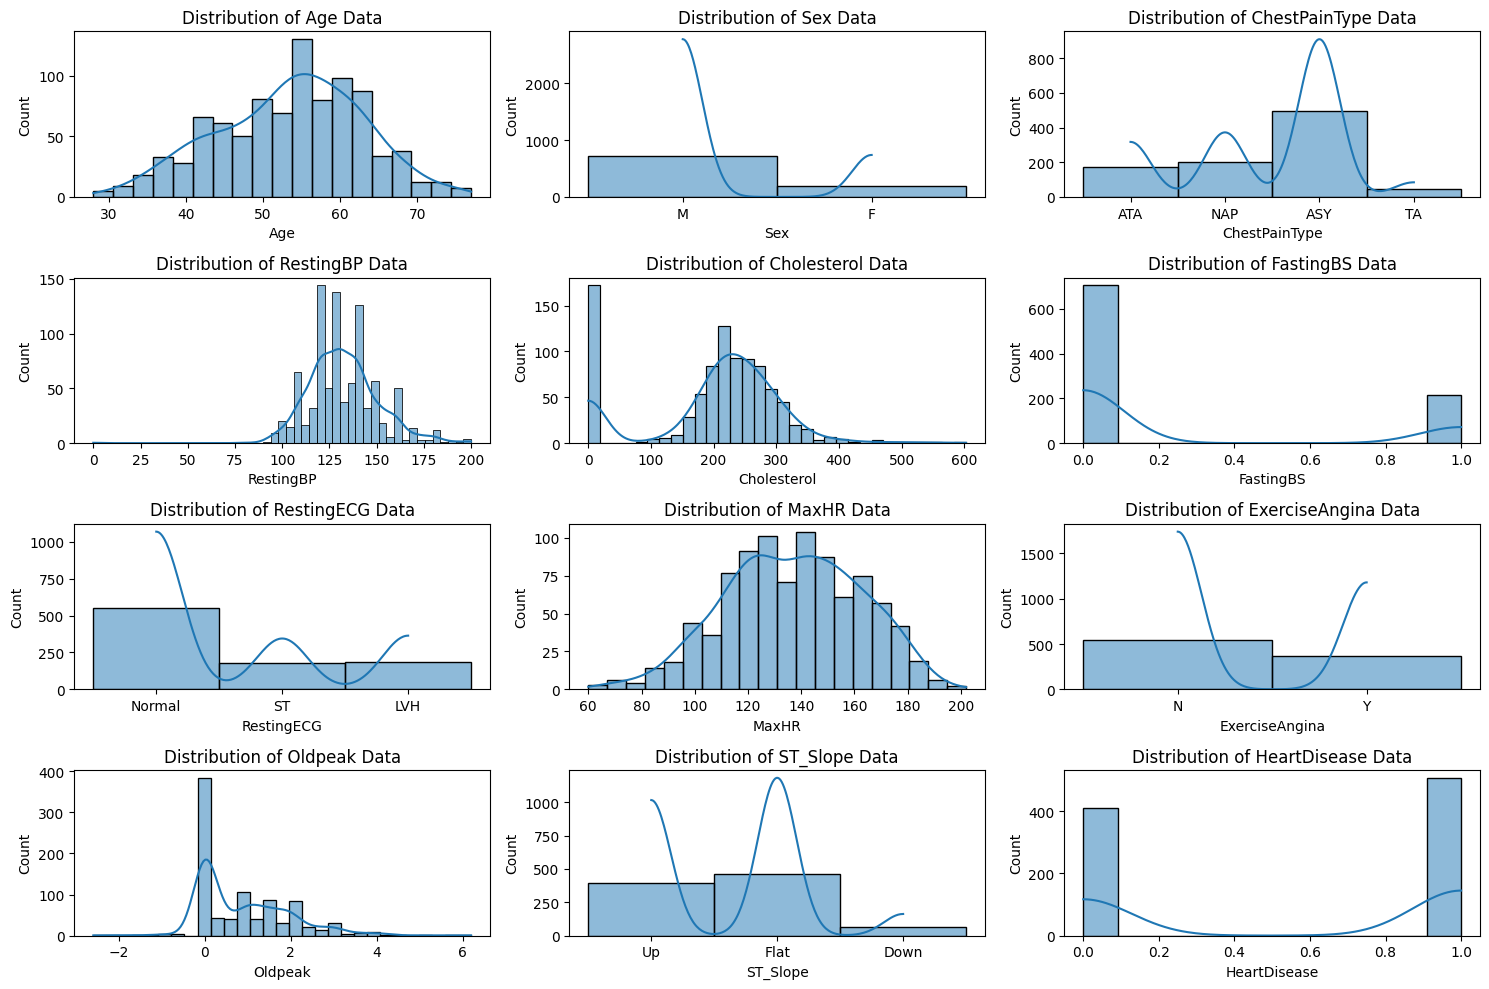

In [28]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

Now consider the presence and number of Outliers by features quartiles using boxplot

In [29]:
fig = px.box(df,y="Age",x="HeartDisease",title=f"Distribution by gender")
fig.show()

In [30]:
fig = px.box(df,y="RestingBP",x="HeartDisease",title=f"Distribution by RestingBP")
fig.show()

In [31]:
fig = px.box(df,y="Cholesterol",x="HeartDisease",title=f"Distribution by Cholesterol")
fig.show()

In [32]:
fig = px.box(df,y="Oldpeak",x="HeartDisease",title=f"Distribution by Oldpeak")
fig.show()

In [33]:
fig = px.box(df,y="MaxHR",x="HeartDisease",title=f"Distribution by MaxHR")
fig.show()

## Data Preprocessing

First, let's apply One Hot Encoding

In [34]:
categorical_features.remove("HeartDisease")

In [35]:
one_hot_X = df.drop("HeartDisease", axis=1)
y = df.HeartDisease

In [36]:
one_hot_X = pd.get_dummies(one_hot_X, columns=categorical_features)

In [37]:
one_hot_X.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,172,0.0,0,1,0,1,0,...,1,0,0,1,0,1,0,0,0,1
1,49,160,180,156,1.0,1,0,0,0,1,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,98,0.0,0,1,0,1,0,...,1,0,0,0,1,1,0,0,0,1
3,48,138,214,108,1.5,1,0,1,0,0,...,1,0,0,1,0,0,1,0,1,0
4,54,150,195,122,0.0,0,1,0,0,1,...,1,0,0,1,0,1,0,0,0,1


Also apply Label Encoding

In [38]:
le = LabelEncoder()
df1 = df
df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])
label_X = df1.drop("HeartDisease", axis=1)
y = df1.HeartDisease

In [39]:
label_X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,1,172,0,0.0,2
1,49,0,2,160,180,0,1,156,0,1.0,1
2,37,1,1,130,283,0,2,98,0,0.0,2
3,48,0,0,138,214,0,1,108,1,1.5,1
4,54,1,2,150,195,0,1,122,0,0.0,2


Now we'll use Scaling

In [40]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

In [41]:
robust_one_hot_X = one_hot_X
robust_label_X = label_X

standard_one_hot_X = one_hot_X
standard_label_X = label_X

minmax_one_hot_X = one_hot_X
minmax_label_X = label_X

In [42]:
robust_one_hot_X[numerical_features] = robust_scaler.fit_transform(one_hot_X[numerical_features])
robust_label_X[numerical_features] = robust_scaler.fit_transform(label_X[numerical_features])

standard_one_hot_X[numerical_features] = standard_scaler.fit_transform(one_hot_X[numerical_features])
standard_label_X[numerical_features] = standard_scaler.fit_transform(label_X[numerical_features])

minmax_one_hot_X[numerical_features] = minmax_scaler.fit_transform(one_hot_X[numerical_features])
minmax_label_X[numerical_features] = minmax_scaler.fit_transform(label_X[numerical_features])

Now let's perform the splitting on the test and training samples

1. One Hot Encoding without Scaling

In [43]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y, test_size=0.33)

2. One Hot Encoding + Robust Scaling

In [44]:
X_train_robust, X_test_robust, y_train_robust, y_test_robust = train_test_split(robust_one_hot_X, y, test_size=0.33, random_state=42)

3. One Hot Encoding + Standard Scaling

In [45]:
X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(standard_one_hot_X, y, test_size=0.33)

4. One Hot Encoding + MinMax Scaling

In [46]:
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(minmax_one_hot_X, y, test_size=0.33)

Now that we have test and training samples with One Hot Encoding and each Scaler, we use training models for which such preprocessing is optimal. That is models that are not tree-based indeed

kNN Method: without Scaler

In [47]:
train_score=[]
test_score=[]

In [48]:
def model_processed(model, params, X_train, X_test, y_train, y_test) -> None:
    classifier = GridSearchCV(model, params, cv=5)
    classifier.fit(X_train, y_train)
    best_classifier = classifier.best_estimator_
    y_train_pred = best_classifier.predict(X_train)
    y_test_pred = best_classifier.predict(X_test)
    train_score.append(accuracy_score(y_train,y_train_pred))
    test_score.append(accuracy_score(y_test,y_test_pred))
    print(classification_report(y_test,y_test_pred))
    print("ROC-AUC score: ", roc_auc_score(y_test, y_test_pred),'\n')
    print("best parameters: ", classifier.best_params_)

In [49]:
param_grid = {'n_neighbors': np.arange(1,30), "weights": ['uniform', 'distance']}
model_kNN = KNeighborsClassifier()

model_processed(model_kNN, param_grid, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       139
           1       0.85      0.93      0.89       164

    accuracy                           0.87       303
   macro avg       0.88      0.87      0.87       303
weighted avg       0.87      0.87      0.87       303

ROC-AUC score:  0.8657439901737147 

best parameters:  {'n_neighbors': 14, 'weights': 'distance'}


kNN: Robust Scaler

In [50]:
model_processed(model_kNN, param_grid, X_train_robust, X_test_robust, y_train_robust, y_test_robust)

              precision    recall  f1-score   support

           0       0.81      0.89      0.84       123
           1       0.92      0.86      0.89       180

    accuracy                           0.87       303
   macro avg       0.86      0.87      0.87       303
weighted avg       0.87      0.87      0.87       303

ROC-AUC score:  0.8708672086720868 

best parameters:  {'n_neighbors': 12, 'weights': 'uniform'}


kNN: Standard Scaler

In [51]:
model_processed(model_kNN, param_grid, X_train_standard, X_test_standard, y_train_standard, y_test_standard)

              precision    recall  f1-score   support

           0       0.92      0.80      0.86       153
           1       0.82      0.93      0.87       150

    accuracy                           0.87       303
   macro avg       0.87      0.87      0.87       303
weighted avg       0.87      0.87      0.87       303

ROC-AUC score:  0.8686274509803922 

best parameters:  {'n_neighbors': 13, 'weights': 'uniform'}


kNN: MinMax Scaler

In [52]:
model_processed(model_kNN, param_grid, X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax)

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       135
           1       0.86      0.88      0.87       168

    accuracy                           0.85       303
   macro avg       0.85      0.85      0.85       303
weighted avg       0.85      0.85      0.85       303

ROC-AUC score:  0.8515873015873016 

best parameters:  {'n_neighbors': 28, 'weights': 'uniform'}


The next model is SVC for which One Hot Encoding is also suitable

SVC: without Scaler

In [53]:
param_grid = {'C': np.arange(0.2, 1.0, 0.2), 'degree': np.arange(3, 9, 3)}
model_SVC = SVC()

model_processed(model_SVC, param_grid, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.92      0.80      0.85       139
           1       0.85      0.94      0.89       164

    accuracy                           0.87       303
   macro avg       0.88      0.87      0.87       303
weighted avg       0.88      0.87      0.87       303

ROC-AUC score:  0.8687927706615196 

best parameters:  {'C': 0.2, 'degree': 3}


SVC: Robust Scaler

In [54]:
model_processed(model_SVC, param_grid, X_train_robust, X_test_robust, y_train_robust, y_test_robust)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       123
           1       0.91      0.85      0.88       180

    accuracy                           0.86       303
   macro avg       0.86      0.86      0.86       303
weighted avg       0.87      0.86      0.86       303

ROC-AUC score:  0.8640243902439025 

best parameters:  {'C': 0.6000000000000001, 'degree': 3}


SVC: Standard Scaler

In [55]:
model_processed(model_SVC, param_grid, X_train_standard, X_test_standard, y_train_standard, y_test_standard)

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       153
           1       0.80      0.95      0.87       150

    accuracy                           0.85       303
   macro avg       0.87      0.86      0.85       303
weighted avg       0.87      0.85      0.85       303

ROC-AUC score:  0.8556862745098038 

best parameters:  {'C': 0.4, 'degree': 3}


SVC: MinMax Scaler

In [56]:
model_processed(model_SVC, param_grid, X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax)

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       135
           1       0.84      0.91      0.87       168

    accuracy                           0.85       303
   macro avg       0.86      0.84      0.85       303
weighted avg       0.85      0.85      0.85       303

ROC-AUC score:  0.8442460317460316 

best parameters:  {'C': 0.2, 'degree': 3}


The next model is a logistic regression

Logistic regression: without Scaler

In [57]:
param_grid = {'C': np.arange(0.2, 1.0, 0.2)}
model_logistic = LogisticRegression()

model_processed(model_logistic, param_grid, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       139
           1       0.86      0.92      0.89       164

    accuracy                           0.88       303
   macro avg       0.88      0.87      0.88       303
weighted avg       0.88      0.88      0.88       303

ROC-AUC score:  0.874034918406738 

best parameters:  {'C': 0.6000000000000001}


Logistic regression: Robust Scaler

In [58]:
model_processed(model_logistic, param_grid, X_train_robust, X_test_robust, y_train_robust, y_test_robust)

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       123
           1       0.92      0.87      0.89       180

    accuracy                           0.88       303
   macro avg       0.87      0.88      0.88       303
weighted avg       0.88      0.88      0.88       303

ROC-AUC score:  0.8804878048780488 

best parameters:  {'C': 0.2}


Logistic regression: Standard Scaler

In [59]:
model_processed(model_logistic, param_grid, X_train_standard, X_test_standard, y_train_standard, y_test_standard)

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       153
           1       0.82      0.96      0.88       150

    accuracy                           0.87       303
   macro avg       0.89      0.88      0.87       303
weighted avg       0.89      0.87      0.87       303

ROC-AUC score:  0.8754248366013071 

best parameters:  {'C': 0.2}


Logistic regression: MinMax Scaler

In [60]:
model_processed(model_logistic, param_grid, X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax)

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       135
           1       0.86      0.88      0.87       168

    accuracy                           0.85       303
   macro avg       0.85      0.85      0.85       303
weighted avg       0.85      0.85      0.85       303

ROC-AUC score:  0.8478835978835979 

best parameters:  {'C': 0.6000000000000001}


The next model is Naive Bayes Classifier

Naive Bayes: without Scaler

In [61]:
param_grid = {}
model_bayes = GaussianNB()

model_processed(model_bayes, param_grid, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       139
           1       0.86      0.90      0.88       164

    accuracy                           0.86       303
   macro avg       0.87      0.86      0.86       303
weighted avg       0.87      0.86      0.86       303

ROC-AUC score:  0.8612914546411651 

best parameters:  {}


Naive Bayes: Robust Scaler

In [62]:
model_processed(model_bayes, param_grid, X_train_robust, X_test_robust, y_train_robust, y_test_robust)

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       123
           1       0.94      0.85      0.89       180

    accuracy                           0.88       303
   macro avg       0.87      0.88      0.88       303
weighted avg       0.89      0.88      0.88       303

ROC-AUC score:  0.884349593495935 

best parameters:  {}


Naive Bayes: Standard Scaler

In [63]:
model_processed(model_bayes, param_grid, X_train_standard, X_test_standard, y_train_standard, y_test_standard)

              precision    recall  f1-score   support

           0       0.89      0.82      0.86       153
           1       0.83      0.90      0.87       150

    accuracy                           0.86       303
   macro avg       0.86      0.86      0.86       303
weighted avg       0.86      0.86      0.86       303

ROC-AUC score:  0.8617647058823529 

best parameters:  {}


Naive Bayes: MinMax Scaler

In [64]:
model_processed(model_bayes, param_grid, X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax)

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       135
           1       0.87      0.85      0.86       168

    accuracy                           0.84       303
   macro avg       0.84      0.84      0.84       303
weighted avg       0.84      0.84      0.84       303

ROC-AUC score:  0.8411375661375662 

best parameters:  {}


The next stage is training models based on decision trees (and their ensembles). In this case we will use Label Encoding, as it is designed for tree-based models

For this purpose, we split the test and training samples using Label Encoding and will use it without any Scalers

Label Encoding without Scaling

In [65]:
X_train, X_test, y_train, y_test = train_test_split(label_X, y, test_size=0.33)

1. As the first tree-based model we take the Decision Tree:

In [66]:
param_grid = {"max_depth": range(2, 20),
              'min_samples_split': range(10, 51, 10),
              'min_samples_leaf': range(10, 201, 10)}

model_des_tree = DecisionTreeClassifier()

model_processed(model_des_tree, param_grid, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.86      0.79      0.83       126
           1       0.86      0.91      0.88       177

    accuracy                           0.86       303
   macro avg       0.86      0.85      0.86       303
weighted avg       0.86      0.86      0.86       303

ROC-AUC score:  0.8516276567124025 

best parameters:  {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 10}


2. Random Forest

In [67]:
param_grid = {'n_estimators': range(10, 100, 30),
              "max_depth": range(2, 10),
              'min_samples_split': [50, 75, 100],
              'min_samples_leaf': [10, 20, 30]}

model_random_forest = RandomForestClassifier()

model_processed(model_random_forest, param_grid, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       126
           1       0.87      0.93      0.90       177

    accuracy                           0.87       303
   macro avg       0.88      0.86      0.87       303
weighted avg       0.88      0.87      0.87       303

ROC-AUC score:  0.8640704869518429 

best parameters:  {'max_depth': 9, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 70}


3. Now use AdaBoost as a gradient boosting algorithm

In [68]:
param_grid = {"n_estimators": [50, 100],
              "learning_rate": [0.1, 0.5, 1, 2]}

model_ada_boost = AdaBoostClassifier()

model_processed(model_ada_boost, param_grid, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.86      0.79      0.83       126
           1       0.86      0.91      0.88       177

    accuracy                           0.86       303
   macro avg       0.86      0.85      0.86       303
weighted avg       0.86      0.86      0.86       303

ROC-AUC score:  0.8516276567124025 

best parameters:  {'learning_rate': 0.1, 'n_estimators': 50}
